In [1]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import display, clear_output
import time

class GridWorldEnv(gym.Env):
    def __init__(self, n=5, start_pos=(0, 0), goal_pos=None, block_percentage=5):
        super().__init__()
        self.n, self.start_pos, self.goal_pos = n, start_pos, goal_pos or (n-1, n-1)
        self.grid_size, self.path, self.current_pos = (n, n), [], self.start_pos
        self.action_space, self.observation_space = spaces.Discrete(4), spaces.Tuple([spaces.Discrete(n)] * 2)
        self.grid = np.zeros(self.grid_size)
        self.blocked_cells = self._generate_blocked_cells(block_percentage)
        self.prev_pos = start_pos
    
    def _generate_blocked_cells(self, block_percentage):
        cells = random.sample([(x, y) for x in range(self.n) for y in range(self.n)
                               if (x, y) != self.start_pos and (x, y) != self.goal_pos],
                              int(self.n**2 * block_percentage / 100))
        for cell in cells:
            self.grid[cell] = -1
        return cells
    
    def reset(self):
        self.path.clear()
        self.current_pos = self.start_pos
        return self.current_pos

    def step(self, action):
        x, y = self.current_pos
        if action == 0: y = max(0, y - 1)
        elif action == 1: y = min(self.n - 1, y + 1)
        elif action == 2: x = max(0, x - 1)
        elif action == 3: x = min(self.n - 1, x + 1)
        next_pos = (x, y)

        if next_pos == self.goal_pos:
            reward = 15000
        elif next_pos in self.blocked_cells:
            reward = -1000
        else:
            reward = -10
            
        done = next_pos == self.goal_pos
        self.prev_pos = self.current_pos
        self.current_pos = next_pos if next_pos not in self.blocked_cells else self.current_pos
        self.path.append(self.current_pos)
        
        return self.current_pos, reward, done, {}

    def render(self, mode='human', sleep_time=0.1):
        self._plot_grid(self.path)
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(sleep_time)
        plt.close()

    def _plot_grid(self, path):
        grid_copy = np.copy(self.grid)
        for p in path:
            grid_copy[p] = 4
        grid_copy[self.start_pos], grid_copy[self.goal_pos], grid_copy[self.current_pos] = 3, 2, 1
        self._draw_grid(grid_copy)

    def _draw_grid(self, grid):
        cmap = colors.ListedColormap(['black', 'white', 'red', 'green', (0.1, 0.7, 0.7, 0.1)])
        norm = colors.BoundaryNorm([-1, 0, 1, 2, 3, 4], cmap.N)
        fig, ax = plt.subplots()
        ax.imshow(grid, cmap=cmap, norm=norm)
        ax.set_xticks(np.arange(self.n) + 0.5, minor=True)
        ax.set_yticks(np.arange(self.n) + 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
        ax.set_xticks([]), ax.set_yticks([])

    def show_final(self):
        self._plot_grid(self.path)
        plt.show()


def plot_q_table(q_table):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    action_labels = ['Left', 'Right', 'Up', 'Down']
    for idx, ax in enumerate(axs.flat):
        heatmap = ax.imshow(q_table[:, :, idx], cmap='viridis', origin='upper', extent=[0, q_table.shape[0], 0, q_table.shape[1]])
        ax.set_title(f"Q-values for {action_labels[idx]}")
        fig.colorbar(heatmap, ax=ax)
        ax.set_xticks(np.arange(q_table.shape[0])), ax.set_yticks(np.arange(q_table.shape[1]))
    plt.tight_layout(), plt.show()


def run(env, q_table, explore=False, epsilon=0.2, p=(0, 0)):
    max_try, state, done = 0, env.reset(), False
    env.current_pos, path = p, []
    env.render()
    while not done and max_try < 1000:
        path.append(state)
        action = env.action_space.sample() if explore and random.uniform(0, 1) < epsilon else np.argmax(q_table[state[0], state[1]])
        state, _, done, _ = env.step(action)
        env.render()
        max_try += 1
    env.show_final()

In [10]:
# Define grid size and blocked cells percentage
n = 10
start_pos = (0, 0)
goal_pos = (n-1, n-1)
block_percentage = 15

env = GridWorldEnv(n=n, start_pos=start_pos, goal_pos=goal_pos, block_percentage=block_percentage)

# Q-learning parameters
q_table = np.zeros((n, n, env.action_space.n))
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 500

rewards_per_episode = []

t = 1
# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit learned values
        
        next_state, reward, done, _ = env.step(action)
        
        # Update Q-value
        q_table[state[0], state[1], action] = q_table[state[0], state[1], action] + alpha * (
            reward + gamma * np.max(q_table[next_state[0], next_state[1]]) - q_table[state[0], state[1], action]
        )
        
        state = next_state
        total_reward += reward
        
        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)

    if (episode + 1) % int(20/epsilon) - 20 == 0:
        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
    
    rewards_per_episode.append(total_reward)
    
print("Training finished!")
print("final qtable shape:", q_table.shape)

Episode 20, Total Reward: -580, Epsilon: 0.9046104802746175
Episode 44, Total Reward: 12760, Epsilon: 0.8020760579717637
Episode 45, Total Reward: 13410, Epsilon: 0.798065677681905
Episode 78, Total Reward: 9250, Epsilon: 0.6763948591909945
Episode 137, Total Reward: 11720, Epsilon: 0.5032248303978422
Episode 140, Total Reward: 12710, Epsilon: 0.49571413690105054
Episode 326, Total Reward: 14830, Epsilon: 0.19513012515638165
Episode 620, Total Reward: 14790, Epsilon: 0.1
Episode 820, Total Reward: 14830, Epsilon: 0.1
Training finished!
final qtable shape: (10, 10, 4)


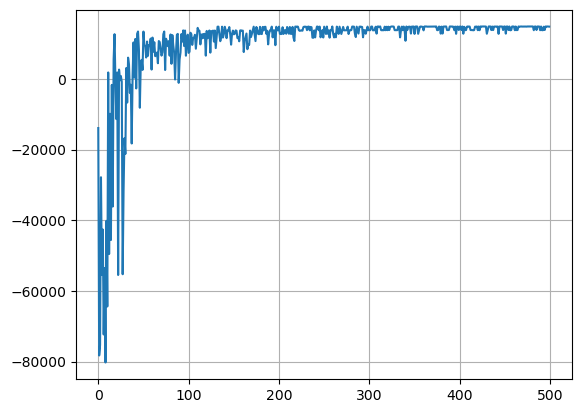

In [11]:
plt.plot(rewards_per_episode[:500])
plt.grid(True)
plt.show()

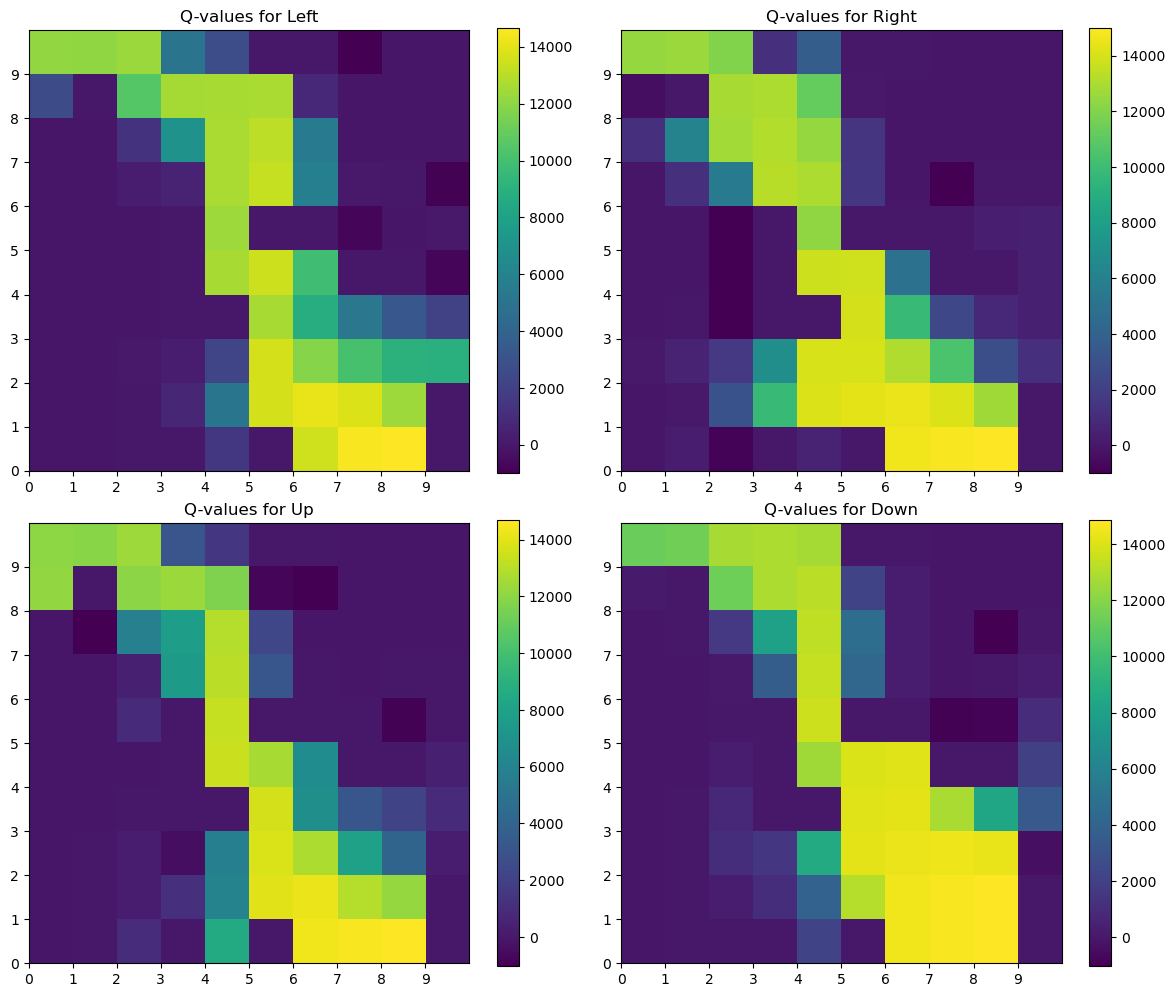

In [12]:
plot_q_table(q_table)

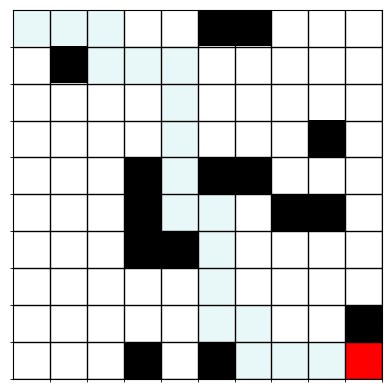

In [13]:
run(env, q_table)

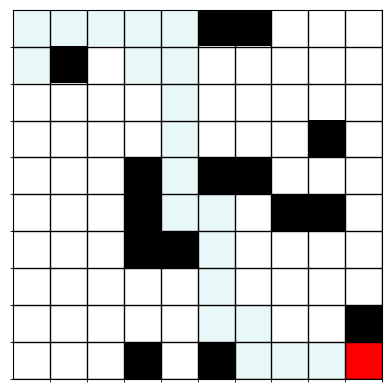

In [14]:
run(env, q_table, explore=True) # 30% case explore